In [107]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from sklearn.preprocessing import StandardScaler
import os

# make a color map dictionary for datasets
datasets = ['jones', 'stiffler', 'haddox', 'doud', 'lee', 'kelsic', 'brenan', 'giacomelli', 'markin', "cov2-S", "cas12f", "zikv-E"]
color_map = {dataset: plt.cm.tab20(i) for i, dataset in enumerate(datasets)}

# show the colors of the color map
for dataset in datasets:
    print(dataset, color_map[dataset])

jones (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0)
stiffler (0.6823529411764706, 0.7803921568627451, 0.9098039215686274, 1.0)
haddox (1.0, 0.4980392156862745, 0.054901960784313725, 1.0)
doud (1.0, 0.7333333333333333, 0.47058823529411764, 1.0)
lee (0.17254901960784313, 0.6274509803921569, 0.17254901960784313, 1.0)
kelsic (0.596078431372549, 0.8745098039215686, 0.5411764705882353, 1.0)
brenan (0.8392156862745098, 0.15294117647058825, 0.1568627450980392, 1.0)
giacomelli (1.0, 0.596078431372549, 0.5882352941176471, 1.0)
markin (0.5803921568627451, 0.403921568627451, 0.7411764705882353, 1.0)
cov2-S (0.7725490196078432, 0.6901960784313725, 0.8352941176470589, 1.0)
cas12f (0.5490196078431373, 0.33725490196078434, 0.29411764705882354, 1.0)
zikv-E (0.7686274509803922, 0.611764705882353, 0.5803921568627451, 1.0)


In [108]:
def name_dataset(df, name, embedding_type = None, esm_type = None):
    df['dataset'] = name
    if embedding_type is not None:
        df['embedding_type'] = embedding_type
    if esm_type is not None:
        df['esm_type'] = esm_type
    return df

def left_join_hie(df):
    # Read the file
    comparison = {'dataset': ['jones', 'stiffler', 'haddox', 'doud', 'lee', 'kelsic', 'brenan', 'giacomelli', 'markin'],
                  'comparison': [0.22, 0.40, 0.23, 0.16, 0.31, 0.50, 0.077, 0.12, 0.20]}
    comparison = pd.DataFrame(comparison)

    # Merge the two dataframes
    df = pd.merge(df, comparison, on='dataset', how='left')

    return df

def read_data(experiment, grid_search_var, columns_to_collapse, esm="esm2", size_pts= "15B", size_csvs = "t48_15B_UR50D"):
    pts_file_names_list = ["kelsic", "brenan", "stiffler", "markin", "giacomelli", "jones", "haddox", "doud", "lee"]
    csvs_file_names_list = ["cov2-S", "cas12f", "zikv-E"]
    all_dfs = []

    for file_name in pts_file_names_list:
        # Read the file from the specified directory
        file_path = f"../../grid_search/results/{esm}_{size_pts}_{file_name}_{experiment}_results.csv"
        individual_df = pd.read_csv(file_path)
        
        # Filter out rows where all columns_to_collapse are None
        individual_df.replace("None", np.nan, inplace=True)
        individual_df = individual_df.dropna(subset=columns_to_collapse, how='all')

        individual_df[columns_to_collapse] = individual_df[columns_to_collapse].apply(pd.to_numeric, errors='coerce')
       
        # Group by simulation number, grid_search_var, and other columns
        grouped = individual_df.groupby(grid_search_var)

        # Calculate mean and standard deviation for specified columns
        stats = grouped[columns_to_collapse].agg(['mean', 'std'])

        # Flatten multi-index columns
        stats.columns = [f'{col}_{stat}' for col, stat in stats.columns]

        # Reset index to make grouped columns regular columns
        stats.reset_index(inplace=True)

        # Add dataset information
        stats = name_dataset(stats, file_name)

        # Append to list of individual DataFrames
        all_dfs.append(stats)

    for file_name in csvs_file_names_list:
    # Read the file from the specified directory
        file_path = f"../../grid_search/results/{file_name}_{esm}_{size_csvs}_{experiment}_results.csv"
        individual_df = pd.read_csv(file_path)
       
        # Filter out rows where all columns_to_collapse are None
        individual_df.replace("None", np.nan, inplace=True)
        individual_df = individual_df.dropna(subset=columns_to_collapse, how='all')

        individual_df[columns_to_collapse] = individual_df[columns_to_collapse].apply(pd.to_numeric, errors='coerce')
       
        # Group by simulation number, grid_search_var, and other columns
        grouped = individual_df.groupby(grid_search_var)

        # Calculate mean and standard deviation for specified columns
        stats = grouped[columns_to_collapse].agg(['mean', 'std'])

        # Flatten multi-index columns
        stats.columns = [f'{col}_{stat}' for col, stat in stats.columns]

        # Reset index to make grouped columns regular columns
        stats.reset_index(inplace=True)

        # Add dataset information
        stats = name_dataset(stats, file_name)

        # Append to list of individual DataFrames
        all_dfs.append(stats)

    # Concatenate all individual DataFrames
    df = pd.concat(all_dfs)

    return df

In [109]:
experiment = "one_shot_average"
grid_search_var = ["num_mutants_per_round", "round_num"]
columns_to_collapse = ["median_fitness_scaled", "top_fitness_scaled", "fitness_binary_percentage"]  # List of columns to collapse
esm = "esm2"
size = "15B"

result_df_one_shot = read_data(experiment, grid_search_var, columns_to_collapse, esm, size)
result_df_one_shot['label'] = "pre-training: " + result_df_one_shot['num_mutants_per_round'].astype(str) + " mutants"

In [110]:
experiment = "15B_average"
grid_search_var = ["num_mutants_per_round", "round_num"]
columns_to_collapse = ["median_fitness_scaled", "top_fitness_scaled", "fitness_binary_percentage"]  # List of columns to collapse
esm = "esm2"
size = "15B"

result_df_rounds = read_data(experiment, grid_search_var, columns_to_collapse, esm, size)
result_df_rounds_subset = result_df_rounds[result_df_rounds['round_num'].isin([5,10])]
result_df_rounds_subset['label'] = "directed evolution: " + result_df_rounds_subset['round_num'].astype(str) + " rounds"

/tmp/ipykernel_1462658/3101270295.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df_rounds_subset['label'] = "directed evolution: " + result_df_rounds_subset['round_num'].astype(str) + " rounds"


In [127]:
hie_data = pd.DataFrame({'dataset': ['jones', 'stiffler', 'haddox', 'doud', 'lee', 'kelsic', 'brenan', 'giacomelli', 'markin'],
              'fitness_binary_percentage_mean': [0.22, 0.40, 0.23, 0.16, 0.31, 0.50, 0.077, 0.12, 0.20],
              'label': ['efficient-evolution'] * 9  # Add 'additional' label for the new rows
             })

In [128]:
hie_data

,dataset,fitness_binary_percentage_mean,label
0,jones,0.220,efficient-evolution
1,stiffler,0.400,efficient-evolution
2,haddox,0.230,efficient-evolution
3,doud,0.160,efficient-evolution
4,lee,0.310,efficient-evolution
5,kelsic,0.500,efficient-evolution
6,brenan,0.077,efficient-evolution
7,giacomelli,0.120,efficient-evolution
8,markin,0.200,efficient-evolution


In [129]:
concatenated_df = pd.concat([result_df_rounds_subset, result_df_one_shot, hie_data], ignore_index=True)

concatenated_df

,num_mutants_per_round,round_num,median_fitness_scaled_mean,median_fitness_scaled_std,top_fitness_scaled_mean,top_fitness_scaled_std,fitness_binary_percentage_mean,fitness_binary_percentage_std,dataset,label
0,16.0,5.0,0.915762,0.008230,0.932545,0.013425,0.970588,0.063537,kelsic,directed evolution: 5 rounds
1,16.0,10.0,0.920548,0.009715,0.939751,0.014564,1.000000,0.000000,kelsic,directed evolution: 10 rounds
2,16.0,5.0,0.605551,0.110643,0.798106,0.181326,0.482353,0.409236,brenan,directed evolution: 5 rounds
3,16.0,10.0,0.627326,0.104616,0.866458,0.178991,0.576471,0.446095,brenan,directed evolution: 10 rounds
4,16.0,5.0,0.914775,0.003471,0.932342,0.007919,0.452941,0.237004,stiffler,directed evolution: 5 rounds
...,...,...,...,...,...,...,...,...,...,...
88,NaN,NaN,NaN,NaN,NaN,NaN,0.310000,NaN,lee,efficient-evolution
89,NaN,NaN,NaN,NaN,NaN,NaN,0.500000,NaN,kelsic,efficient-evolution
90,NaN,NaN,NaN,NaN,NaN,NaN,0.077000,NaN,brenan,efficient-evolution
91,NaN,NaN,NaN,NaN,NaN,NaN,0.120000,NaN,giacomelli,efficient-evolution


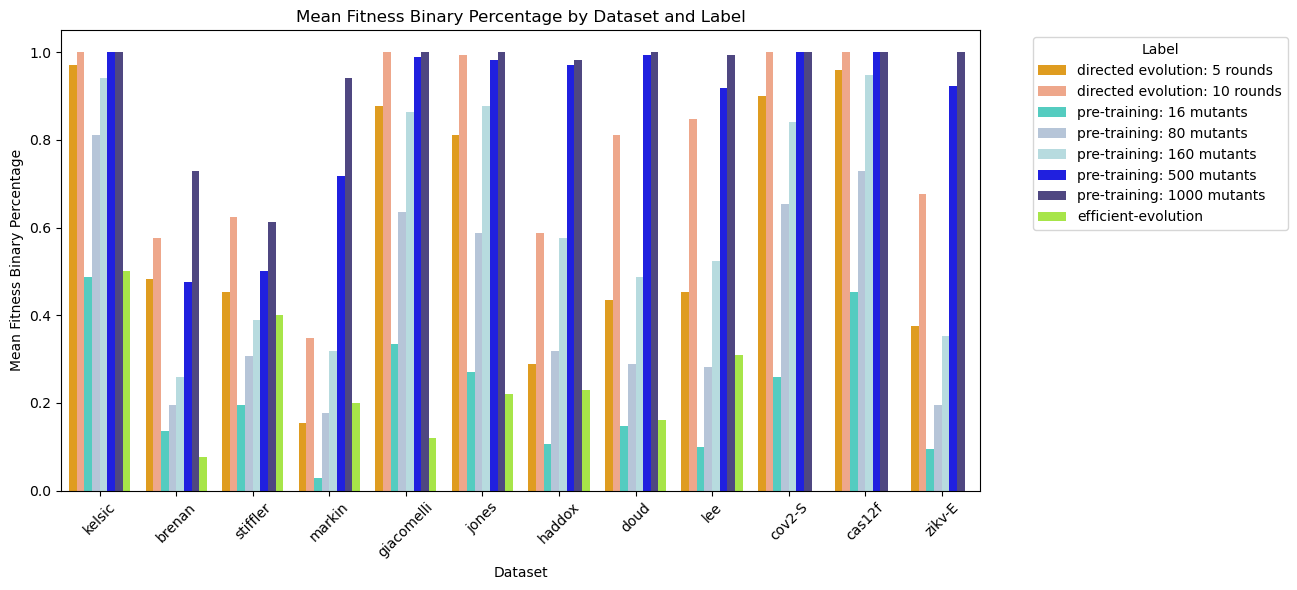

In [130]:
# Define the colors for each hue level
palette_colors = {'efficient-evolution': 'greenyellow', 
                  
                  'pre-training: 16 mutants': 'turquoise', 
                  'pre-training: 80 mutants': 'lightsteelblue',
                  'pre-training: 160 mutants': 'powderblue',
                  'pre-training: 500 mutants': 'blue',
                  'pre-training: 1000 mutants': 'darkslateblue',

                  'directed evolution: 5 rounds': 'orange',
                  'directed evolution: 10 rounds': 'lightsalmon'}

# Create the bar plot with hue and error bars
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=concatenated_df, x='dataset', y='fitness_binary_percentage_mean', hue='label', 
            palette=palette_colors)

x_coords = [p.get_x() + 0.5 * p.get_width() for p in ax.patches]
y_coords = [p.get_height() for p in ax.patches]

# ax.errorbar(x=x_coords, y=y_coords, yerr=concatenated_df["fitness_binary_percentage_std"], fmt="none", capsize=2, c="k")

# Add labels and title
plt.xlabel('Dataset')
plt.ylabel('Mean Fitness Binary Percentage')
plt.title('Mean Fitness Binary Percentage by Dataset and Label')

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.legend(title='Label', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [112]:
result_df_rounds

,num_mutants_per_round,round_num,median_fitness_scaled_mean,median_fitness_scaled_std,top_fitness_scaled_mean,top_fitness_scaled_std,fitness_binary_percentage_mean,fitness_binary_percentage_std,dataset
0,16,1,0.891572,0.018516,0.929018,0.021244,0.488235,0.216664,kelsic
1,16,2,0.905238,0.011271,0.929556,0.015437,0.711765,0.259313,kelsic
2,16,3,0.911129,0.010404,0.930216,0.014780,0.858824,0.232334,kelsic
3,16,4,0.912382,0.010397,0.931536,0.013554,0.923529,0.184042,kelsic
4,16,5,0.915762,0.008230,0.932545,0.013425,0.970588,0.063537,kelsic
...,...,...,...,...,...,...,...,...,...
5,16,6,0.100178,0.045513,0.495964,0.151167,0.447059,0.157352,zikv-E
6,16,7,0.114928,0.027088,0.499743,0.151641,0.470588,0.190105,zikv-E
7,16,8,0.123457,0.030596,0.601869,0.123799,0.535294,0.171946,zikv-E
8,16,9,0.141009,0.026279,0.601869,0.123799,0.600000,0.163582,zikv-E


In [113]:
def plot_round_by_round_comparison(df, output_var, ax = None, comparison=False):
    if ax is None:
        plt.figure(figsize=(10, 6))
        ax = plt.gca()

    # Left join the comparison values
    df = left_join_hie(df)

    # Create a color map for datasets
    datasets = df['dataset'].unique()

    # Plot each dataset and embedding type as a separate line
    for i, dataset in enumerate(datasets):
        dataset_df = df[(df['dataset'] == dataset)]
        x_values = dataset_df['round_num']
        y_values = dataset_df[output_var]
        error_values = dataset_df['fitness_binary_percentage_std']
        y_value_min = y_values - error_values
        y_value_max = y_values + error_values
        color = color_map[dataset]  # Corrected line

        # Plot the line with error bars
        ax = sns.lineplot(x=x_values, y=y_values, ax=ax, marker='o', color=color, label=dataset)
        # ax.fill_between(x_values, y_value_min, y_value_max, alpha=0.2)
        # ax.errorbar(x=x_values, y=y_values, yerr=error_values, fmt="none", capsize=2, c="k")

        if comparison:
            comparisons = dataset_df['comparison']
            for k, comparison_value in enumerate(comparisons):
                if not np.isnan(comparison_value):
                    # Create an interpolation function for the line
                    line_interp = interp1d(x_values, y_values, kind='linear', fill_value='extrapolate')
    
                    # Find the intersection point with the comparison value
                    intersection_x = np.interp(comparison_value, y_values, x_values)
                    intersection_y = line_interp(intersection_x)
    
                    # Plot the dash marker at the intersection point
                    ax.scatter(intersection_x, intersection_y, color='black', s=200, marker='_', zorder=5, label='_nolegend_')
    
    # Add labels and title
    ax.set_xlabel('Number of Iterations')
    ax.set_ylabel(output_var.replace('_', ' ').title())
    ax.set_title(f'{output_var.replace("_", " ").title()} by Iterations')
    
    # Show the legend
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    # Show the plot
    plt.show()

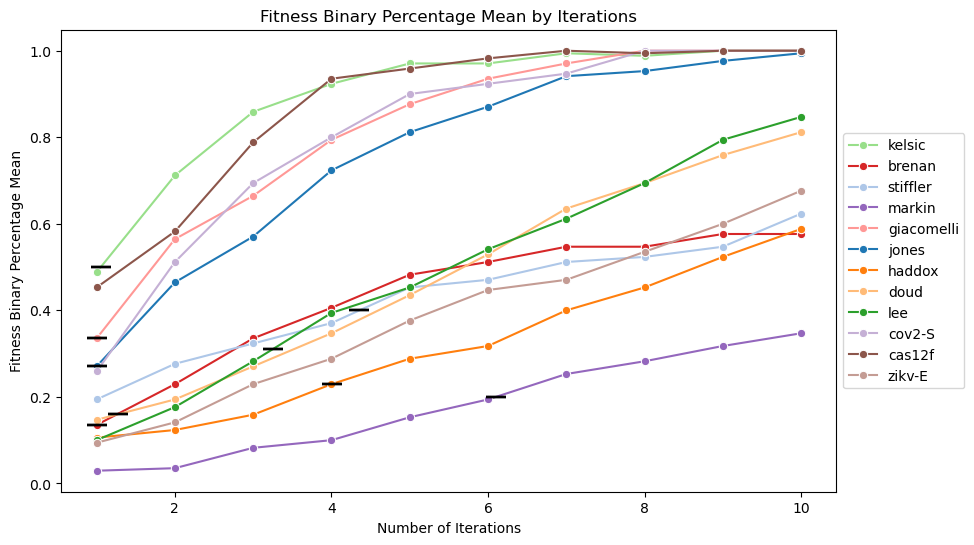

In [114]:
plot_round_by_round_comparison(result_df_rounds, 'fitness_binary_percentage_mean', comparison=True)